In [1]:
from packaging import version
import sklearn
import tensorflow as tf

- 텐서플로 데이터 API는 대규모 데이터셋을 효율적으로 로드하고 전처리할 수 있도록 한다.
- 텐서플로가 멀티스레딩, 큐, 배치, 프리페치 같은 상세한 사항을 모두 대신 처리해준다.
- 또한 데이터 API는 tf.keras와도 잘 동작한다.

이 장에서는 데이터 API, TFRecord 포맷을 다루고 사용자 정의 전처리 층을 만드는 방법과 표준 케라스 전처리 층을 사용하는 법을 다룬다.

# 1. 데이터 API
- from_tensor_slices() 함수는 텐서를 받아 X의 각 원소가 아이템으로 표현되는 tf.data.Dataset을 만든다.<br>
    - 즉 데이터셋은 0,1,2,,9에 해당하는 10개의 아이템을 가진다.

In [2]:
X = tf.range(10) # 데이터 텐서
dataset = tf.data.Dataset.from_tensor_slices(X) # 메모리 전체에서 데이터셋 생성
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
# make dict
X_neated = {"a": ([1,2,3],[4,5,6]), "b":[7,8,9]}
dataset = tf.data.Dataset.from_tensor_slices(X_neated)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## 1. 연쇄변환
데이터셋이 준비되면 변환 메서드를 호출하여 여러 종류의 변환을 수행할 수 있다.
- repeat(x) 메서드: 반복횟수. 원본 데이터셋의 아이템을 x차례 반복하는 새로운 데이터셋 반환
- batch(x) 메서드: 배치크기

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
dataset_dr = dataset.repeat(3).batch(7, drop_remainder=True) # drop_remainder=True로 하면 남은 [8 9]는 drop
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


map으로 데이터 변환<br>
- num_parallel_calls 매개변수로 여러 스레드로 나누어 속도를 높일 수 있음.
- map() 메서드에 전달하는 함수는 텐서플로 함수로 변환 가능해야 함.

In [6]:
# 각 아이템에 *2 해주기
dataset = dataset.map(lambda x:x * 2) # x는 배치
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


2023-08-08 15:06:11.948019: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
# reduce_sum : 텐서의 모든 성분의 총합을 계산하는 함수
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [8]:
# 위의 dataset 중에서 2개만 보고싶을 때
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


## 2. Shuffling the data
경사 하강법은 훈련셋에 있는 샘플이 독립적이고 동일한 분포일 때 최고 성능을 발휘한다. shuffle() 메서드로 간단하게 샘플을 섞어 데이터 분포를 적절하게 만들 수 있다.<br>
- shuffle() 메서드<br>
  [동작순서]<br>
    1. 먼저 원본 데이터셋의 처음 아이템은 buffer_size 개수만큼 추출하여 버퍼에 채운다.
    2. 그다음 새로운 아이템이 요청되면 이 버퍼에서 비워진 버퍼를 채운다.
    3. 원본 데이터셋의 모든 아이템이 사용될 때까지 반복된다.
    4. 그다음엔 버퍼가 비워질 때까지 계속라여 랜덤하게 아이쳄을 반환한다.
  - 이 메서드를 사용하려면 버퍼 크기를 지정해야 한다. 메모리를 넘지 않는 선에서 버퍼 크기를 충분히 크게 하는 것이 중요하다.<br>
 
⬇︎ 정수 0에서 9까지 세 번 반복된 데이터셋을 만든 다음, 버퍼 크기 4, 랜덤 시드 42를 사용하여 셔플링하고, 배치 크기 7로 나누어 출력

In [9]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


❗️셔플된 데이터셋이 repeat() 메서드를 호출하면 기본적으로 반복마다 새로운 순서를 생성한다.<br> 하지만 반복마다 동일한 순서를 사용해야 한다면 repeat() 메서드에 reshuffle_each_iteration=False를 지정해야 한다.
### 여러 파일에서 한 줄씩 번갈아 읽기
⬇︎ california_housing dataset 실습

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [11]:
# 데이터셋을 10개 파일로 분할하여 csv로 저장
import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ','.join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [12]:
# 위의 csv 파일 중 하나의 처음 몇 줄 살펴보기
print("".join(open(train_filepaths[0]).readlines()[:10]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621
2.0549,13.0,5.312457454050374,1.0850918992511913,3297.0,2.2443839346494214,33.93,-116.93,0.956
2.9583,50.0,5.380281690140845,1.1173708920187793,579.0,2.7183098591549295,33.98,-118.06,1.726
3.52,23.0,4.698216735253772,1.0342935528120714,2202.0,3.0205761316872426,34.14,-118.01,1.873
2.7188,32.0,5.511627906976744,1.067829457364341,1337.0,2.5910852713178296,34.94,-120.42,1.337
2.6563,26.0,4.29489291598023,1.1235584843492588,1401.0,2.3080724876441514,37.68,-122.08,1.841



In [13]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

### 입력 파이프라인 구축
기본적으로 list_files() 함수는 파일 경로를 섞은 데이터셋을 반환한다. 이를 원하지 않는다면 shuffle=False로 지정하면 된다. 하지만 일반적으로 shuffle을 한다.

In [14]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [15]:
# filepath가 섞여있음을 보여줌
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [16]:
n_readers = 8
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip(1): 열 이름은 스킵
    cycle_length=n_readers)

interleave() 메서드는 filepath_dataset에 있는 다섯 개의 파일 경로에서 데이터를 읽는 데이터셋을 만든다.<br>
이 메서드에 전달한 lambda 함수는 각 파일에 대해 호출하여 새로운 데이터셋(위의 경우 TextLineDataset)을 만들 것이다.

list

In [17]:
# 데이터 확인
for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


## 3. 전처리

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [19]:
X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8

# csv한 라인을 받아 파싱
def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs) # io.decode_csv() 함수로 파싱: 열마다 한 개씩 스칼라 텐서의 리스트를 반환
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

# 
def preprocess(line):
    x, y, = parse_csv_line(line)
    return (x - X_mean) / X_std, y # 스케일 조정

In [20]:
preprocess(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205')[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.8936168 ,  0.9789995 , -0.6810549 , -0.07264194, -0.5669866 ,
       -0.39212456, -1.3522334 ,  1.2316071 ], dtype=float32)>

## 4. 데이터 적재와 전처리를 합치기
마지막 라인의 **prefetch(1)** 는 성능에 아주 중요한 역할을 한다.
- prefetch(1)을 호출하면 훈련 알고리즘이 한 배치로 작업을 하는 동안 이 데이터셋이 다름 배치를 준비한다.
- interleave()와 map() 메서드를 호출할 때 num_parallel_calls 매개변수를 지정하여 멀티스레드로 데이터를 적재하고 전처리하면 CPU의 멀티 코어를 활용하여 매우 빠른 시간 안에 한 배치 데이터를 준비할 수 있다.
- 위와 같은 방법으로 GPU를 100% 활용할 수 있다. 결국 prefetch로 CPU와 GPU를 동시에 사용한다. GPU가 한 배치를 처리할 때 CPU가 그다음 배치를 준비한다.

⬇︎ 데이터셋을 효율적으로 적재, 전처리, 셔플링, 반복, 배치를 적용한 데이터셋 만들어 반환<br>
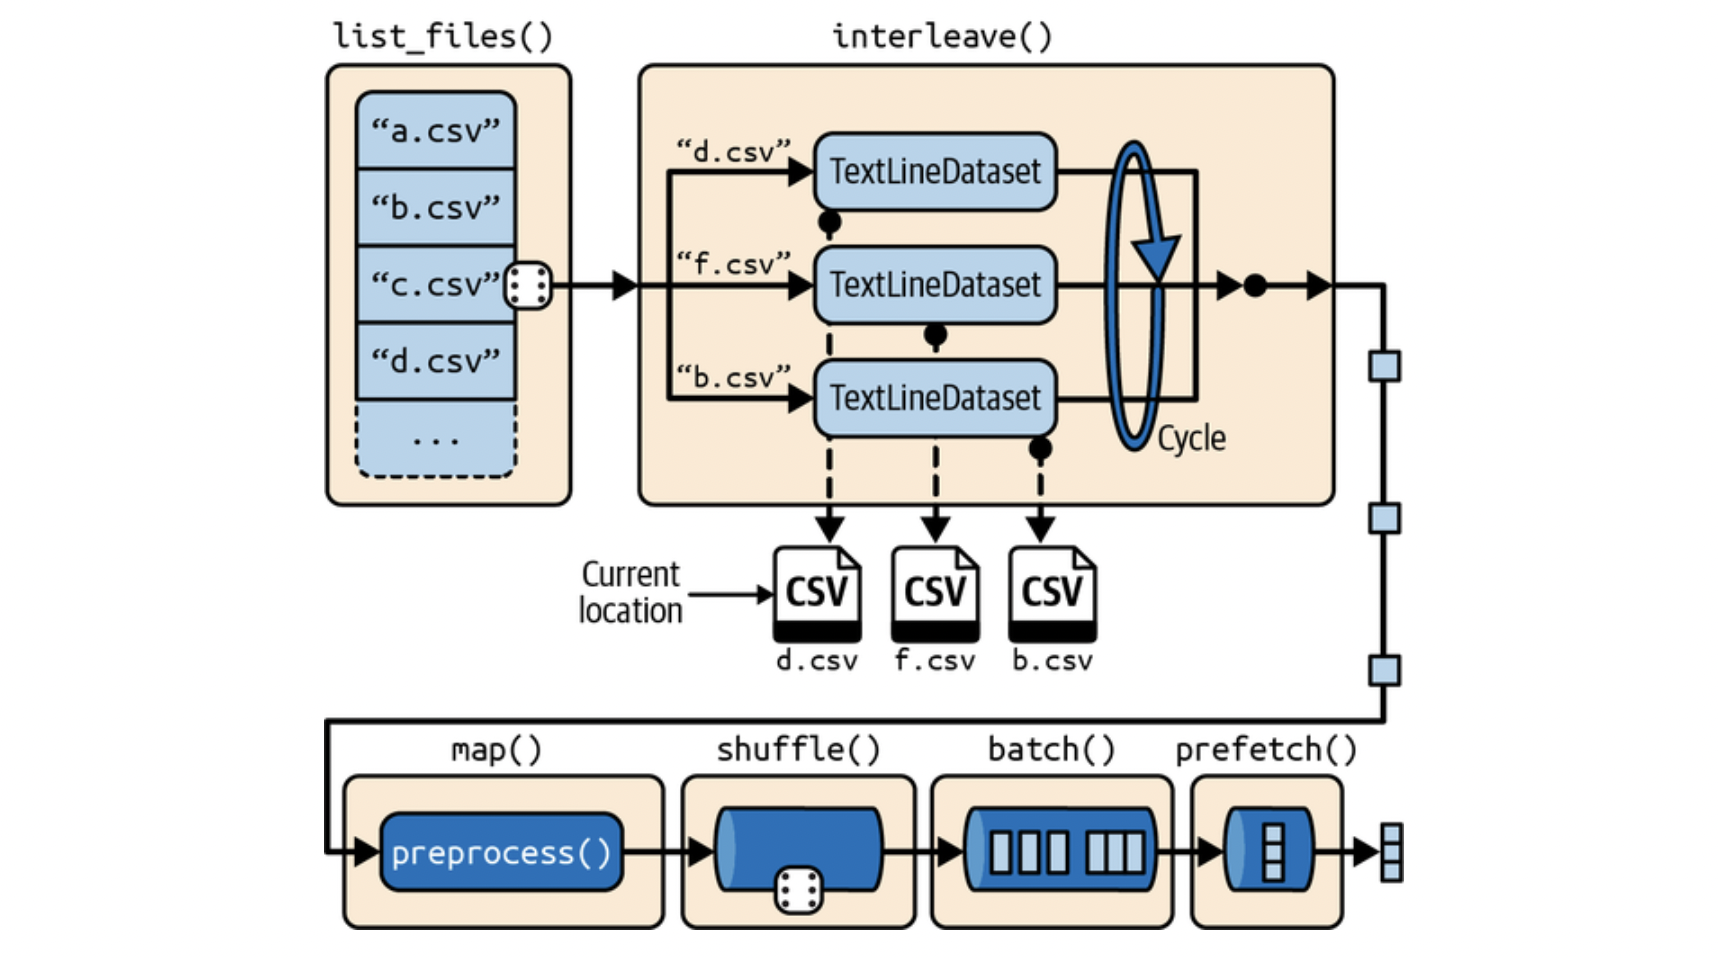

In [21]:
def csv_reader_dataset(filepaths, n_readers=3, n_read_threads=None,
                      n_parse_threads=3, shuffle_buffer_size=10_000, seed=42,
                      batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [22]:
# 데이터셋에서 생성된 처음 몇 개의 배치 출력
example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-0.102321   -0.04940685 -0.26123708 -0.2140565  -0.6390827  -0.03635615
   1.0838584  -1.2272451 ]
 [-0.7242854   1.8491895  -0.18279862 -0.14786676  0.31368068 -0.2919014
   0.938631   -0.70748705]
 [ 2.4207332  -0.20762321  0.28157145 -0.28884298  0.03989811 -0.26936856
  -0.71510154  0.6118972 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.657  ]
 [1.19   ]
 [5.00001]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-1.1625149   0.5043504  -0.06089423  0.17347346 -0.267651    0.26266304
   0.42798868  0.16710497]
 [ 1.1320231   0.42524222  0.637564   -0.26336434 -0.5222688  -0.07005388
  -0.84627515  0.82679707]
 [-0.63812697  0.1879177  -0.68644917 -0.14255631  1.7017584   0.9543124
  -0.8931223   0.8567819 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.591]
 [2.871]
 [1.585]], shape=(3, 1), dtype=float32)



## 5. tf.keras와 데이터셋 사용하기
앞서 만든 csv_reader_dataset() 함수로 훈련 셋으로 사용할 데이터셋 만들기!
- tf.keras에서 반복을 처리하므로 반복을 지정할 필요가 없다.

In [23]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [24]:
# 재현성 보장하기
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [25]:
# train
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                         input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 5ms/step - loss: 1.0545 - val_loss: 10.2691
Epoch 2/5
363/363 [==============================] - 2s 4ms/step - loss: 3.2622 - val_loss: 17.5388
Epoch 3/5
363/363 [==============================] - 2s 4ms/step - loss: nan - val_loss: nan
Epoch 4/5
363/363 [==============================] - 2s 4ms/step - loss: nan - val_loss: nan
Epoch 5/5
363/363 [==============================] - 2s 5ms/step - loss: nan - val_loss: nan


In [26]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)
y_pred = model.predict(new_set)

3/3 [==============================] - 0s 9ms/step


In [37]:
# 훈련을 위한 optimizer 및 loss function 정의
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # 경사 하강법 스탭 하나 수행
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [40]:
# 전체 훈련 반복 수행하는 함수(Tensorflow ver)
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
        # 경사 하강법 스탭 하나 수행
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

# 2. Keras Preprocessing Layers
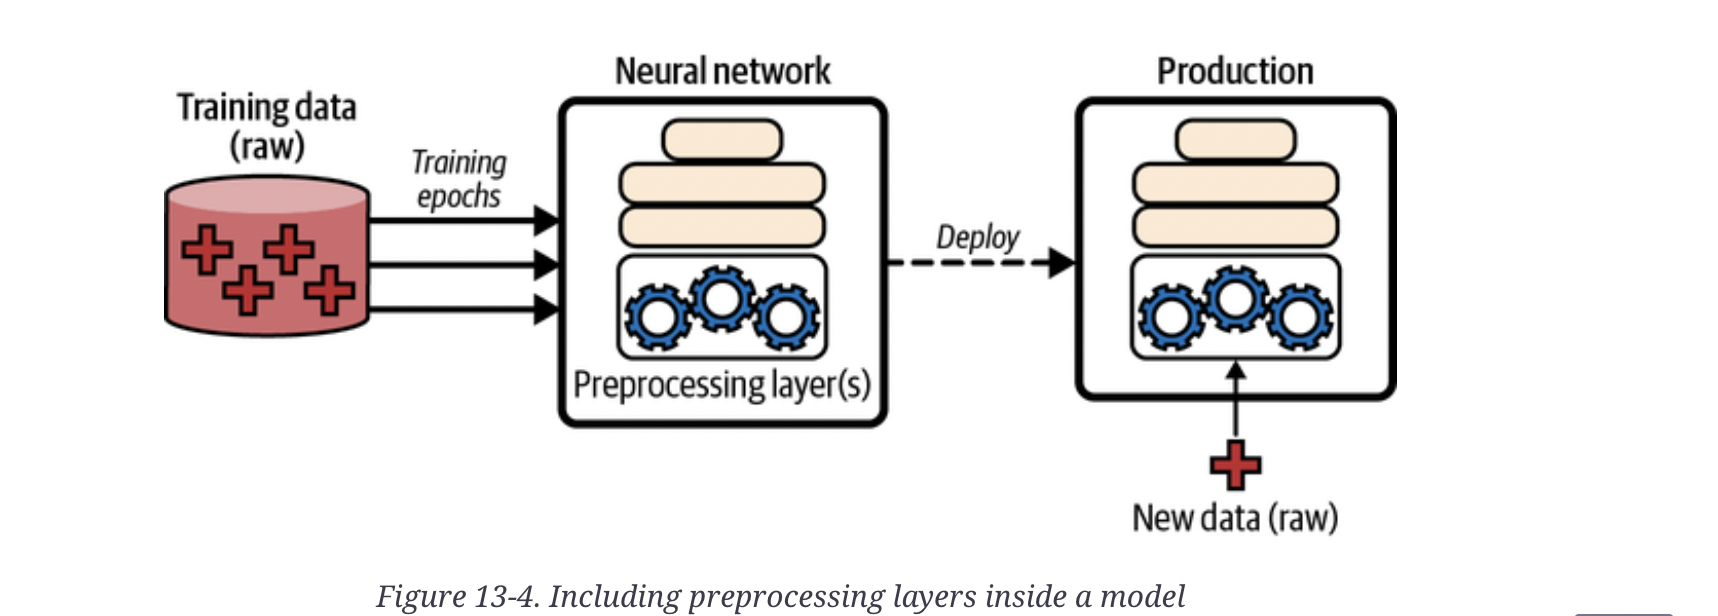<br>
 This approach completely eliminates the risk of preprocessing mismatch, which happens when people try to maintain different preprocessing code for training and production but update one and forget to update the other. The production model then ends up receiving data preprocessed in a way it doesn’t expect. If they’re lucky, they get a clear bug. If not, the model’s accuracy just silently degrades.
## 1. The Normalization Layer
We can either specify the mean and variance of each feature when creating the layer or—more simply—pass the training set to the layer’s adapt() method before fitting the model, so the layer can measure the feature means and variances on its own before training.
- sample data가 adapt() 메서드를 통과할 때는 full data는 아니더라도 데이터셋의 특성을 충분히 반영할 정도 크기의 데이터셋을 넣어야 한다. 정규화 layer에서 몇 백개의 샘플이 

In [41]:
tf.random.set_seed(42) # 재현성 보장
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train) # 모든 특성의 평균과 분산 계산
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 5ms/step - loss: 2.6967 - val_loss: 0.8915
Epoch 2/5
363/363 [==============================] - 2s 5ms/step - loss: 0.7261 - val_loss: 1.6333
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.6250 - val_loss: 1.1285
Epoch 4/5
363/363 [==============================] - 2s 4ms/step - loss: 0.6014 - val_loss: 0.8000
Epoch 5/5
363/363 [==============================] - 2s 4ms/step - loss: 0.5895 - val_loss: 0.5620


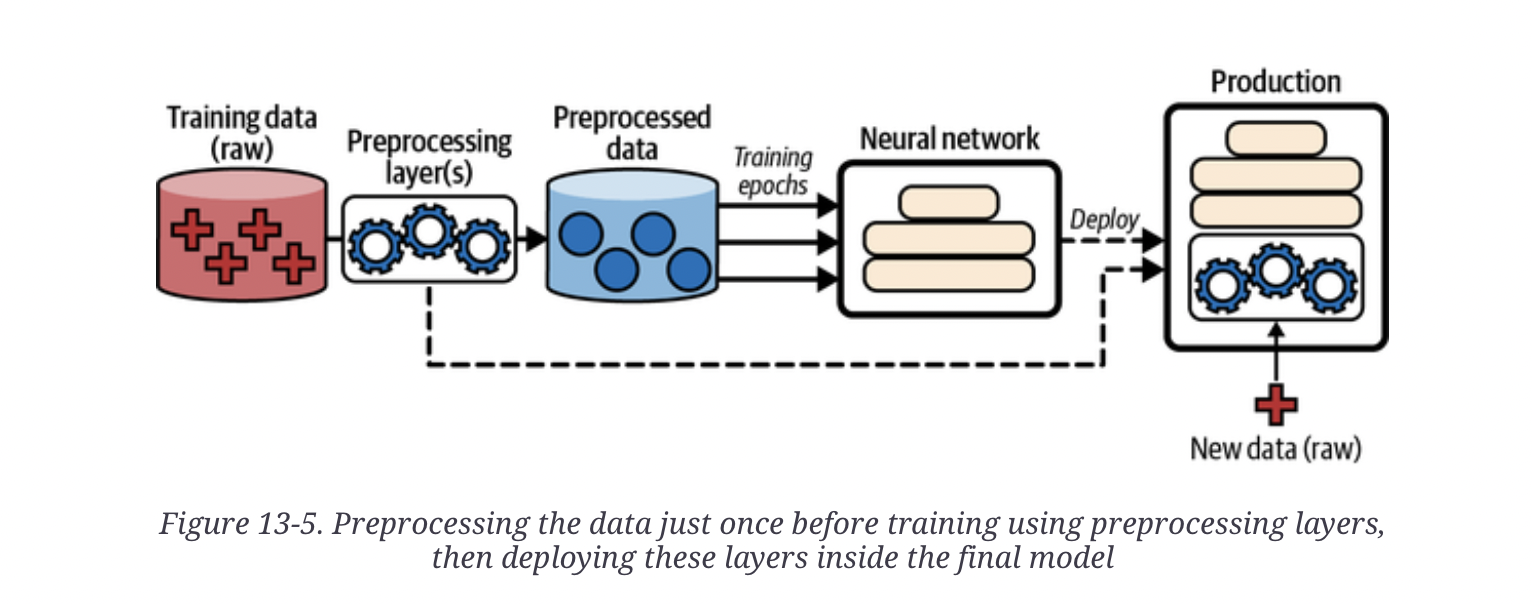<br>
⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎

In [50]:
# use the Normalization layer in a standalone fashion (much like a Scikit-Learn StandardScaler)
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

# training a model on the scaled data, this time without a Normalization layer
tf.random.set_seed(42)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5, 
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 2.6971 - val_loss: 1.3550
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 0.8110 - val_loss: 2.0179
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.6999 - val_loss: 1.3276
Epoch 4/5
363/363 [==============================] - 1s 4ms/step - loss: 0.6617 - val_loss: 0.8929
Epoch 5/5
363/363 [==============================] - 1s 4ms/step - loss: 0.6376 - val_loss: 0.6119


In [51]:
# creating a new model that wraps both the adapted Normalization layer and the model we just trained.
# it will take care of both preprocessing its inputs and making predictions.
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3] # 스케일링되지 않은 새 인스턴스 몇 개가 있다고 가정
y_pred = final_model(X_new)
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.0133466],
       [1.574529 ],
       [2.4323678]], dtype=float32)>

In [52]:
#  It’s also possible to apply a Keras preprocessing layer to a tf.data.Dataset using the dataset’s map() method instead adapt() method.
# map()을 사용하여 norm_layer에 적용하는 데모용 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
dataset = dataset.map(lambda X, y: (norm_layer(X), y))
list(dataset.take(1)) # 첫 번째 배치

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397898, -1.0778134 , -0.94338703,  0.0148516 ,  0.02073434,
          -0.5729169 ,  0.9292593 , -1.4221286 ],
         [ 0.7519828 , -1.8688954 ,  0.40547714, -0.23327833,  1.8614666 ,
           0.20516504, -0.91654944,  1.0966994 ],
         [-0.4146912 ,  0.02970134,  0.8180874 ,  1.056782  , -0.08786613,
          -0.29983333,  1.3087262 , -1.697002  ],
         [ 1.7188952 , -1.315138  ,  0.3266428 , -0.21955259, -0.337921  ,
          -0.11146676, -0.9821362 ,  0.94177276],
         [-0.96207213, -1.2360299 , -0.05625897, -0.03124549,  1.709061  ,
          -0.3025704 , -0.8041136 ,  1.326592  ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

## 2. The Discretization Layer
to transform a numerical feature into a categorical feature by mapping value ranges (called bins) to categories.

In [53]:
# a numerical age feature to three categories, less than 18, 18 to 50 (not included), and 50 or over
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [55]:
# if we set num_bins=3, then the bin boundaries will be located at the values just below the 33rd and 66th percentiles (in this example, at the values 10 and 37)
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

## 3. The CategoryEncoding Layer
one-hot encode the age_​cate⁠gories feature

In [56]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [57]:
# more than one categorical feature at a time, he CategoryEncoding class will perform multi-hot encoding by default.
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [58]:
# to know how many times each category occurred, you can set output_mode="count"
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

# 모르겠다? 어째서 2랑 5랑 똑같이 인코딩 되는거지..?

In [61]:
# [0, 1]과 [1, 0]을 다르게 인코딩하기 위함. 아래 아웃풋을 기준으로 0은 [0,1,0]으로 1은[1,0,0]으로 표현됨
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # 두 번째 특성에 3을 추가합니다.

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [63]:
onehot_layer(two_age_categories + [0, 3])  # 두 번째 특성에 3을 추가합니다.

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [62]:
two_age_categories + [0, 3]

array([[1, 3],
       [2, 5],
       [2, 3]])

In [65]:
# 각 기능을 개별적으로 원핫 인코딩하기
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3,
                                               output_mode="one_hot")
tf.keras.layers.concatenate([onehot_layer(cat)
                            for cat in tf.transpose(two_age_categories)])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [66]:
# tf.one_hot() 및 flatten을 사용해서 인코딩하기
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>